In [3]:
import sys, os
import numpy as np

sys.path.append(os.path.join(os.path.pardir, 'python'))
from tcg_slb.phasediagram.scipy import ScipyPDReactiveODE
from tcg_slb.phasediagram.base import PDReactiveGrid, PDReactiveGridDiagnostics
from tcg_slb.base import *

In [4]:
pv = repr(sys.version_info.major)+'.'+repr(sys.version_info.minor)
sys.path.append(os.path.join(os.path.pardir, 'database', 'install', 'MgFeSiO4_all_slb_rx', 'lib', 'python'+pv, 'site-packages'))

import py_MgFeSiO4_all_slb_rx as tcgdb
rxn = tcgdb.MgFeSiO4_all_slb_rx()
rxn.report()

Reaction object: MgFeSiO4_all_slb_rx

Phase 0 Olivine_slb_ph (ol)
     Endmember 0 Forsterite_slb_em : Mg2SiO4_(ol)
     Endmember 1 Fayalite_slb_em : Fe2SiO4_(ol)
Phase 1 Wadsleyite_slb_ph (wa)
     Endmember 0 MgWadsleyite_slb_em : Mg2SiO4_(wa)
     Endmember 1 FeWadsleyite_slb_em : Fe2SiO4_(wa)
Phase 2 Ringwoodite_slb_ph (ri)
     Endmember 0 MgRingwoodite_slb_em : Mg2SiO4_(ri)
     Endmember 1 FeRingwoodite_slb_em : Fe2SiO4_(ri)
Phase 3 MgFePerovskite_slb_ph (mgfepv)
     Endmember 0 MgPerovskite_slb_em : MgSiO3_(mgfepv)
     Endmember 1 FePerovskite_slb_em : FeSiO3_(mgfepv)
Phase 4 Magnesiowuestite_slb_ph (mw)
     Endmember 0 Periclase_slb_em : MgO_(mw)
     Endmember 1 Wuestite_slb_em : FeO_(mw)
Phase 5 Stishovite_slb_ph (st)
     Endmember 0 Stishovite_slb_em : SiO2_(st)

Reaction 0
     Mg2SiO4_(ol) -> Mg2SiO4_(wa)
Reaction 1
     Fe2SiO4_(ol) -> Fe2SiO4_(wa)
Reaction 2
     Mg2SiO4_(ol) -> Mg2SiO4_(ri)
Reaction 3
     Fe2SiO4_(ol) -> Fe2SiO4_(ri)
Reaction 4
     Mg2SiO4_(wa) 

### Setup ODE

In [5]:
ode = ScipyPDReactiveODE(rxn)

#### Temperature, pressure, composition

In [6]:
# initial temperature, pressure and phase volume fraction
Ti = 1673.                # Kelvin
pi = GPa2Bar(30.)         # bars
Ci0 = [0.8, 0.2]
i0 =  0                   # initial phase index

#### Initial conditions

In [7]:
mi0 = np.zeros(ode.I)
mi0[i0] = 1.
Cik0 = np.zeros(ode.K)
for i in range(ode.I):
    if ode.Kis[i] == 1:
        Cik0[sum(ode.Kis[:i]):sum(ode.Kis[:i+1])] = 1.
    else:
        Cik0[sum(ode.Kis[:i]):sum(ode.Kis[:i+1])][:] = np.asarray(Ci0)

display(mi0, Cik0)

array([1., 0., 0., 0., 0., 0.])

array([0.8, 0.2, 0.8, 0.2, 0.8, 0.2, 0.8, 0.2, 0.8, 0.2, 1. ])

### Solve the system of reactive ODEs at a fixed pressure and temperature

In [15]:
ode.solve(Ti,pi,mi0,Cik0,1000.0)

In [18]:
ode.excstr

'AttributeError("\'py_MgFeSiO4_all_slb_rx.MgFeSiO4_all_slb_rx\' object has no attribute \'check_coder_error\'")'

In [10]:
ode.final_phases(1.e-2)

AssertionError: 

## Plotting

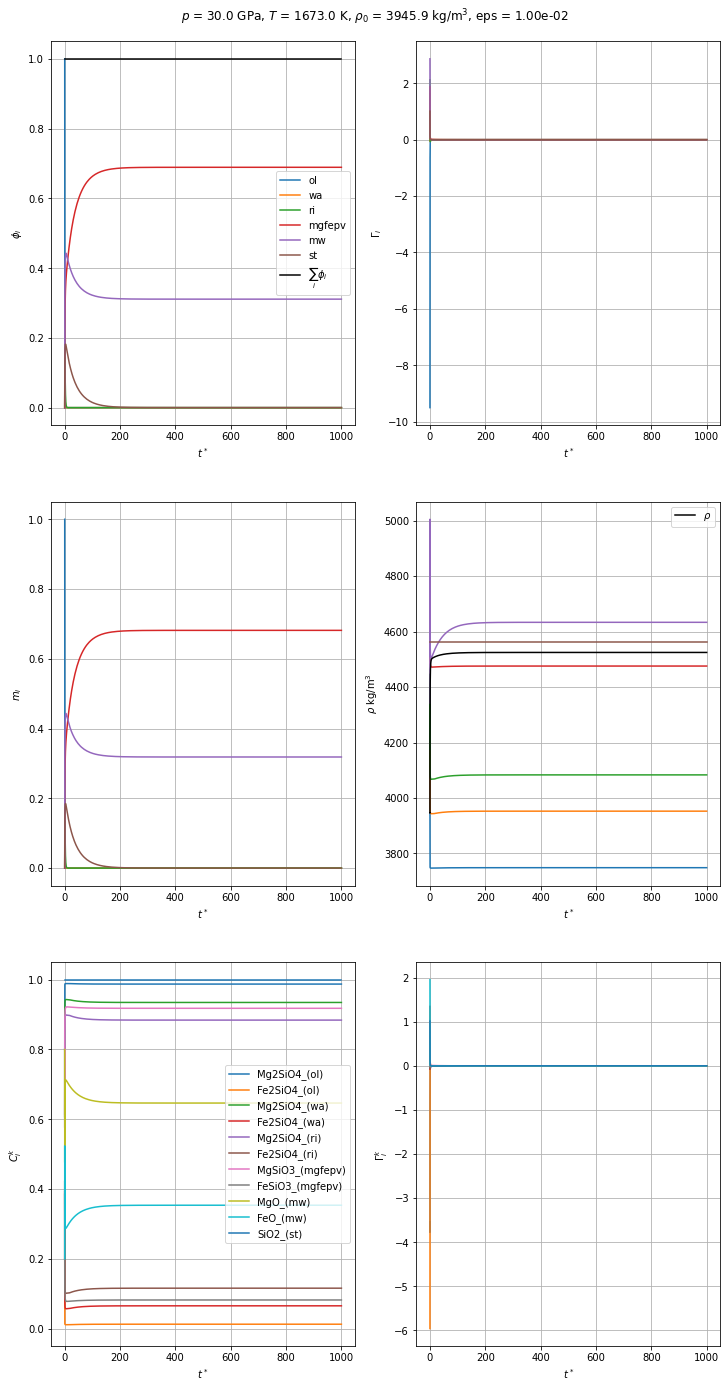

In [9]:
ode.plot()

## Solve for a grid

In [10]:
reload = True

import pickle

filename = os.path.join('output', 'scipy_bdfgrid_mgfesio4_lowp.pickle')

if reload:
    pfile = open(filename, 'rb')
    bdfgrid = pickle.load(pfile)
    pfile.close()
else:
    i0 = 0
    p_n = 60
    p_min = 0.0 + 0.5*30/p_n
    p_max = 30.0 - 0.5*30/p_n
    p_range = np.linspace(p_min, p_max, p_n)
    x_n = 50
    x_min = 0.5/x_n
    x_max = 1. - 0.5/x_n
    x_range = np.linspace(x_min, x_max, x_n)
    end = 1e5
    bdfgrid = PDReactiveGrid()
    bdfgrid.solve(rxn, ScipyPDReactiveODE, i0, ['Xi0k0', 'p'], x_range, p_range, end, **{'T':Ti})

In [11]:
save = True

if not reload and save:
        pfile = open(filename, 'wb')
        pickle.dump(bdfgrid, pfile)
        pfile.close()

In [12]:
import matplotlib.pyplot as plt

def decorate(pdrgd):
    def new_setup_axes(self,axi):
        img = plt.imread("figures/slb_figure10a.png")
        ip = axi.imshow(img)
        axi.axis('off')
        ax = axi.inset_axes([0.002,0.004,0.995,0.996])
        ax.patch.set_alpha(0.0)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 30.0])
        ax.set_ylabel("Pressure (GPa)")
        ax.set_xlabel("Initial $X_{Mg_2SiO_4}$")
        ax.invert_xaxis()
        return ax
    
    #replace the display with newdisplay
    pdrgd.setup_axes = new_setup_axes
    
    #return the modified student 
    return pdrgd

bdfdiag = decorate(PDReactiveGridDiagnostics)(rxn,bdfgrid)

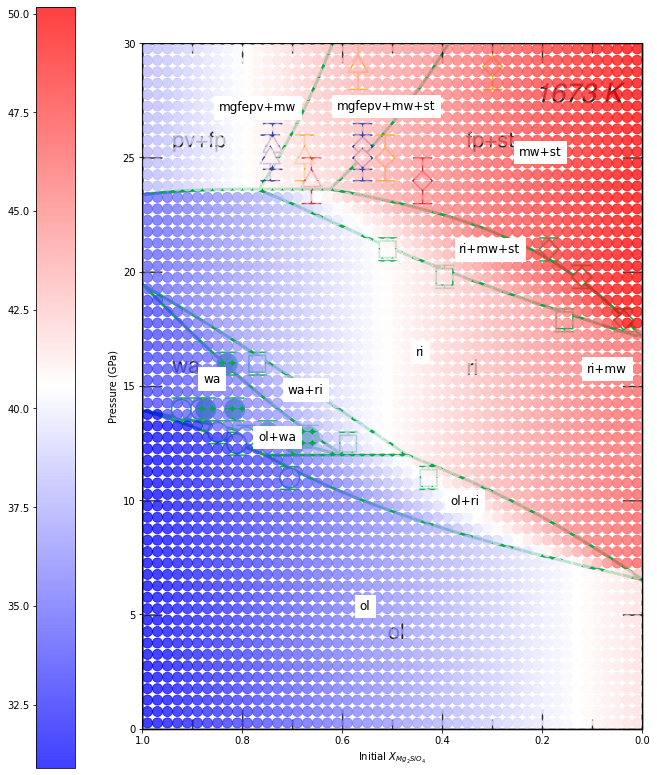

In [13]:
bdfdiag.plot_rho()

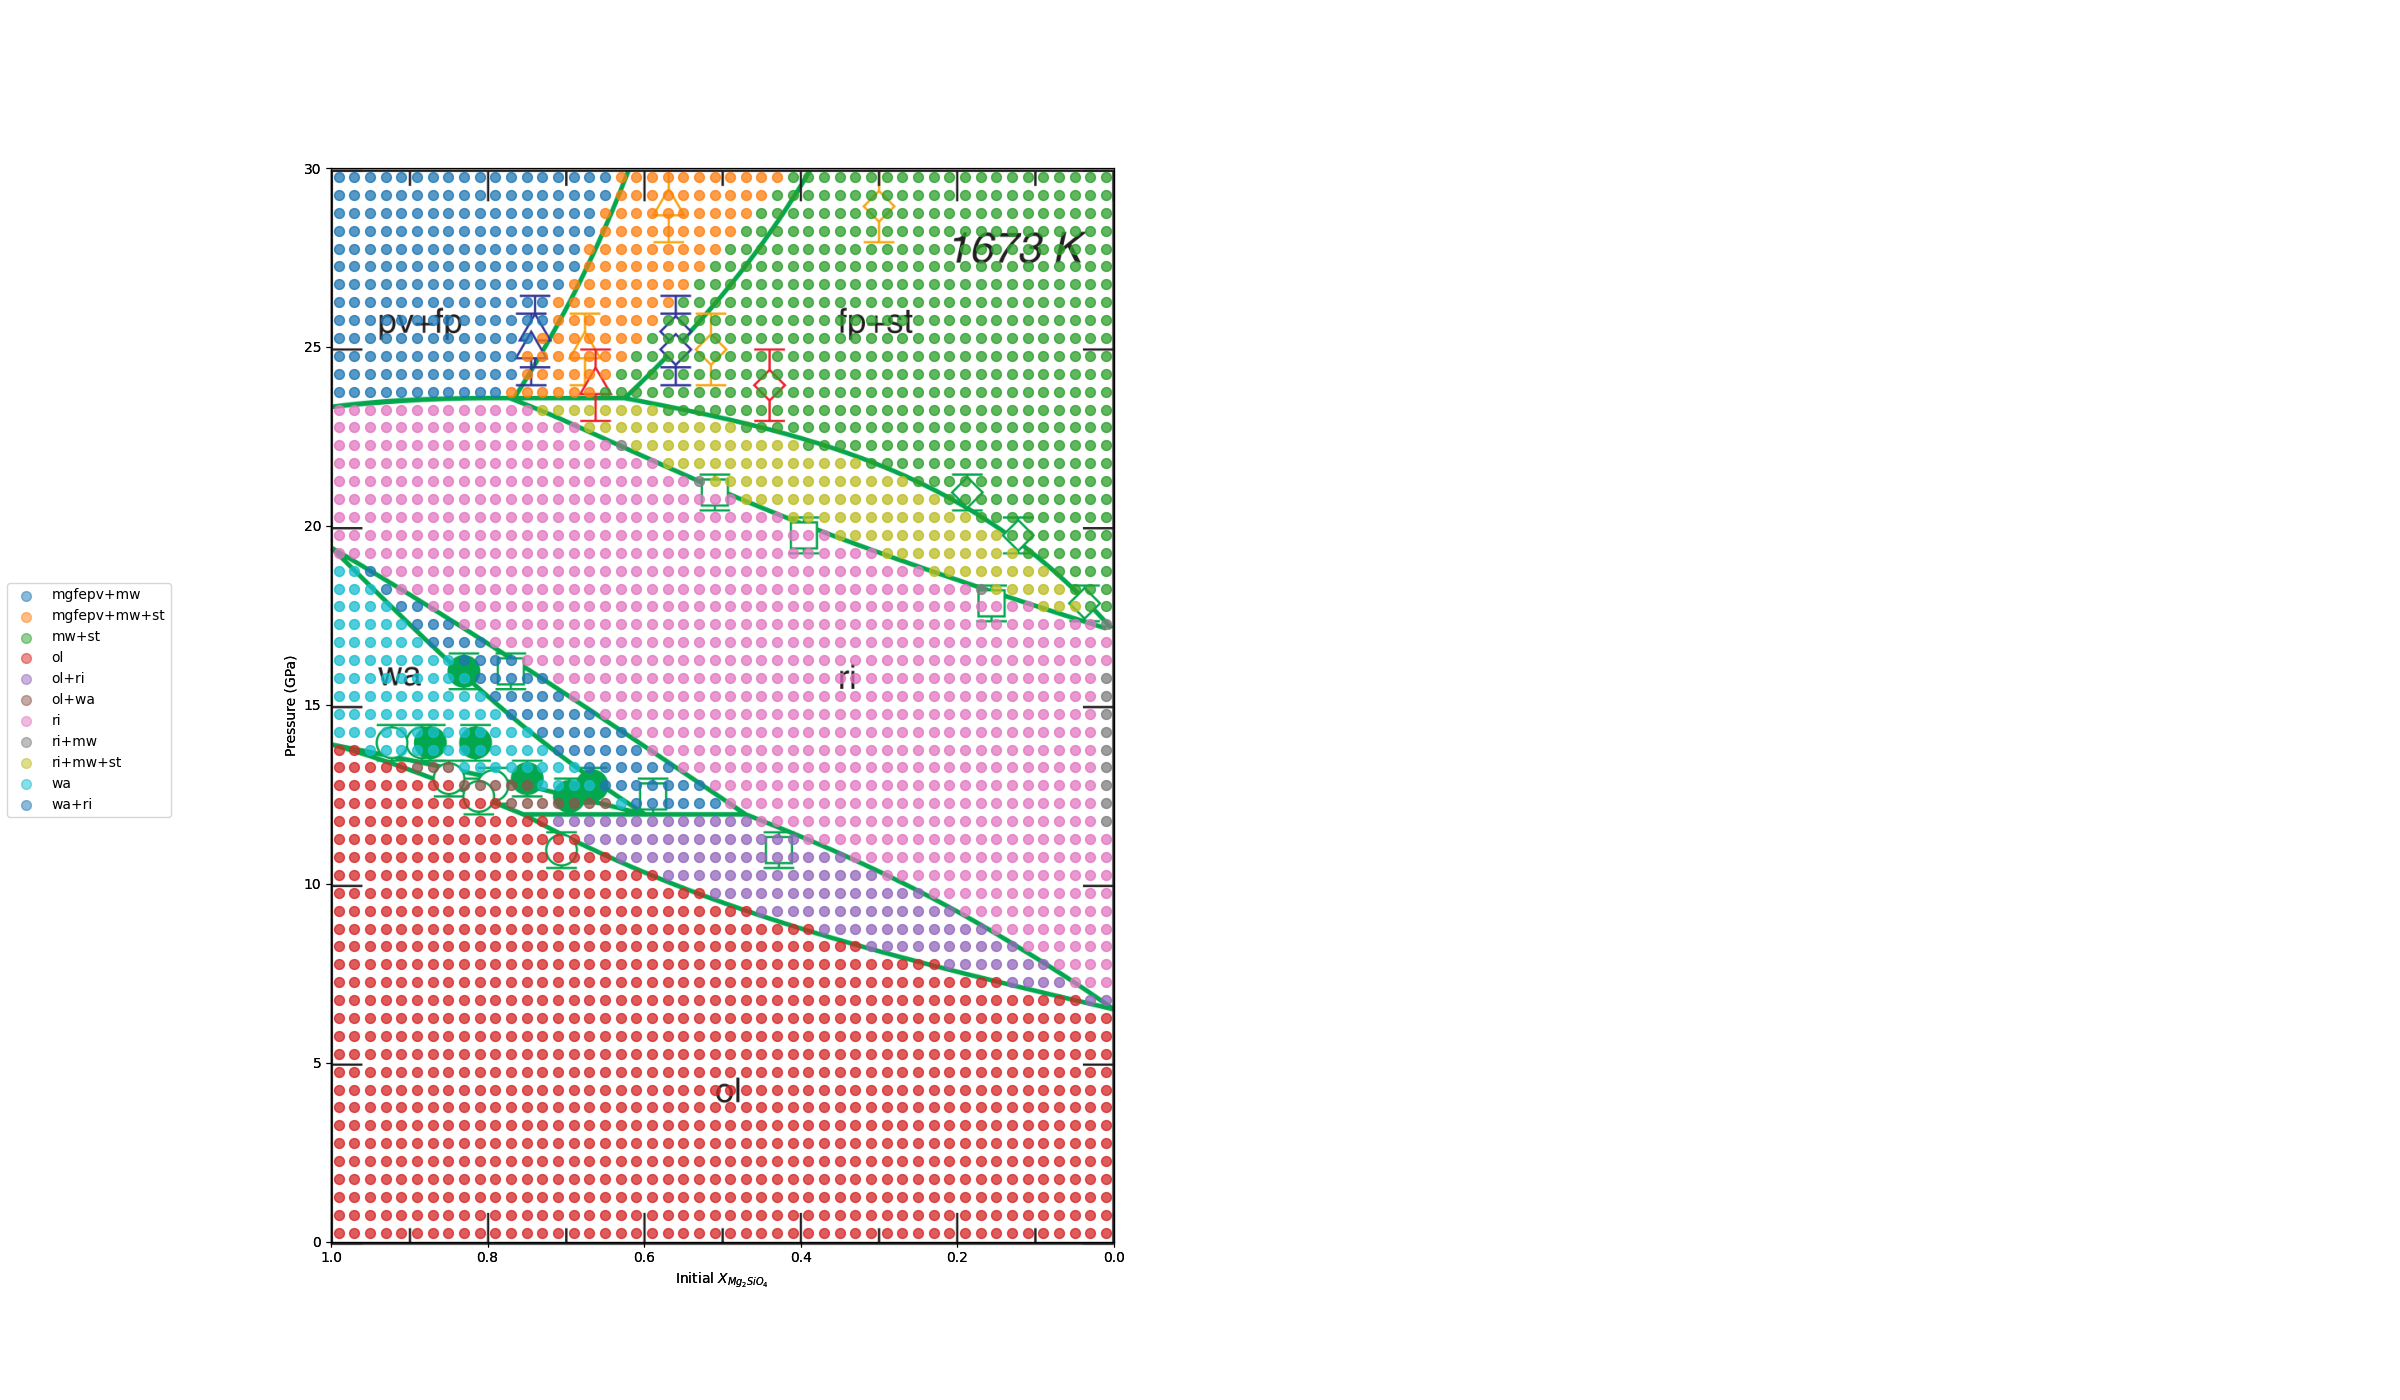

In [19]:
%matplotlib widget
bdfdiag.plot_phases()

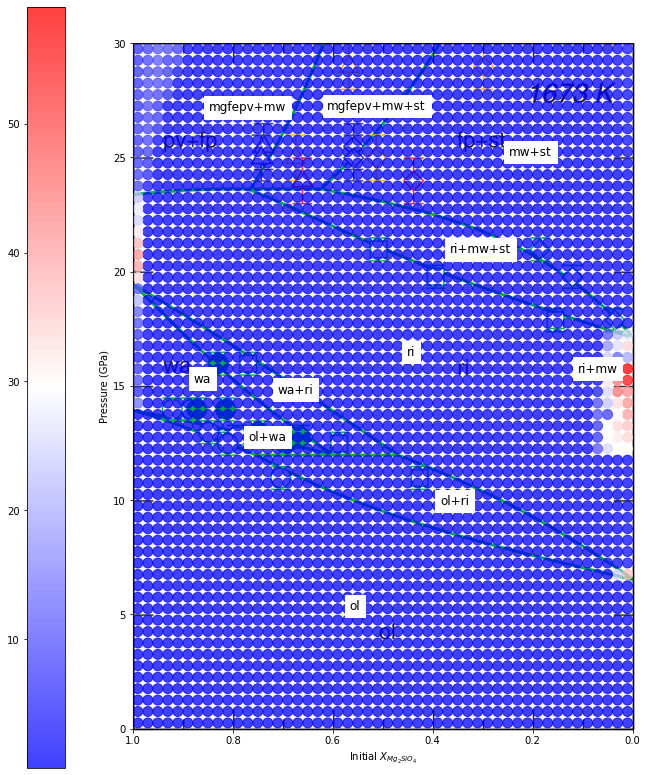

In [15]:
%matplotlib inline
bdfdiag.plot_stime()

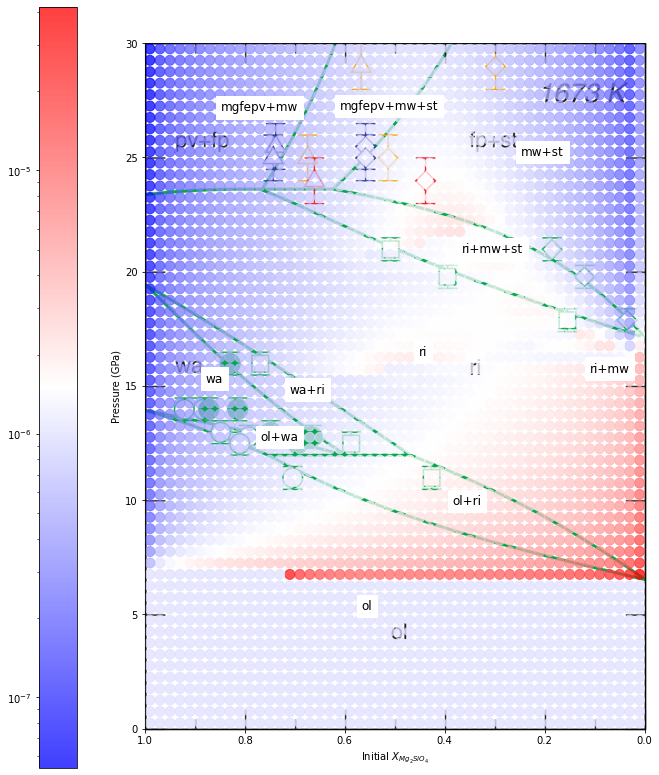

In [16]:
bdfdiag.plot_mindt()

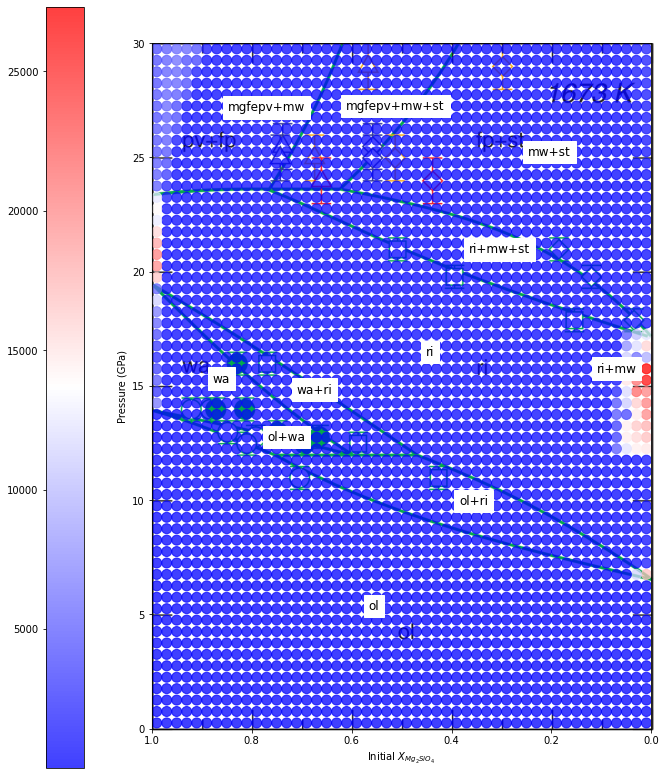

In [17]:
bdfdiag.plot_ndt()

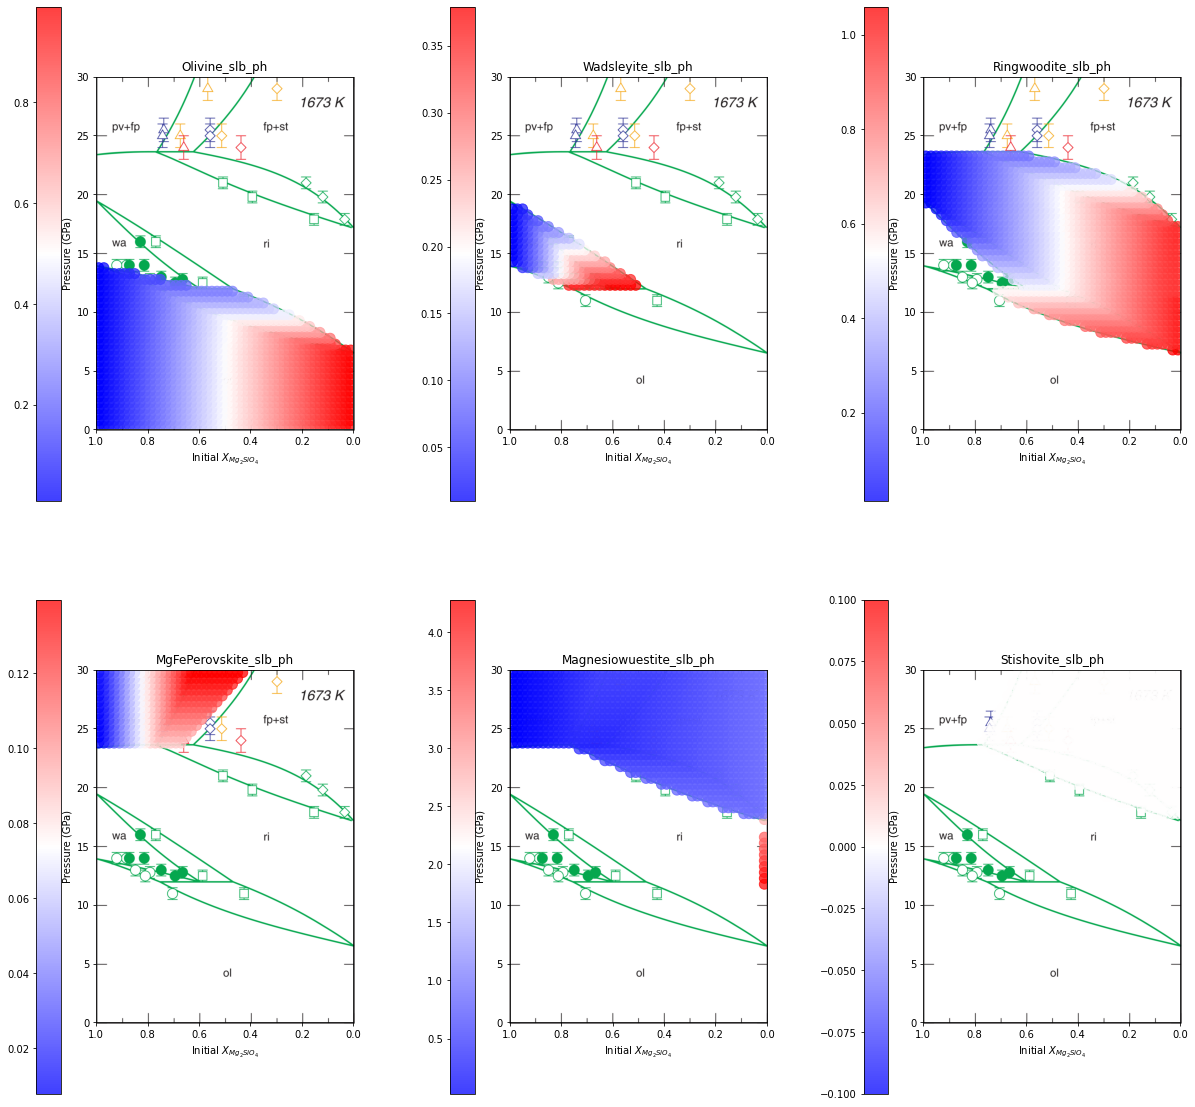

In [18]:
bdfdiag.plot_Xi1()